# Note about submission

Please zip your flask app, sqlite database, tests, jupyter notebook, data csv, and any other relevant files for your submission

# Part 1

### Create a simple pet tracking flask app that uses sqlalchemy to write to a sqlite database.

The app will have three endpoints 

### NewestPet
**Name** | **Method** | **Description** 
--- | --- | ---
`/newestpet` | `GET` | Returns the information about the most recently added pet

**Parameters**

None

---

### PetWithName
**Name** | **Method** | **Description** 
--- | --- | ---
`/petwithname` | `GET` | Returns a list of all pets with the provided name, or an empty list

**Parameters**

**Type**: URL parameter

**Name**: `name`

**DataType**: `string`

**Required**: required

**Description**: name to search for

---

### AddPet
**Name** | **Method** | **Description** 
--- | --- | ---
`/addpet` | `POST` | Adds a pet to the database

**Parameters**

None

**Body**

```
{
    "name": <str: name of the pet>,
    "breed": <str: beed of the pet, one of {“dog”, “cat”}>
}
```
---

### Other requirements
1. The `Pet` sqlalchemy object should have the following method: `to_json() -> str` which converts the pet to a json object `{ “name”: pet.Name, “breed”: pet.Breed }`
2. The sqlite database should have only a single table, which includes `ID`, `Name`, `Breed`

# Part 2

Writes tests for your app using `pytest`

# Part 3

Imagine your job is to help build the text processing pipeline for a machine learning model. This model takes strings, processes them into vectors, and then classifies the text as relating to one of several categories (a multiclass classifier).

The raw data that is passed into the machine learning pipeline has strings that may include descriptions of many items, including multiple items that we are seeking to classify, as well as descriptions of items that are irrelevant to our classifier. These must be separated before being passed to classifier.

As the newest member of the team, your job is to get up to speed with the data as quickly as possible, and to find opportunities to improve the text processing pipeline. Perform an EDA on the following CSV to accomplish this. Be prepared to explain what insights you learned from the data, and what approaches you might use to improve the pipeline.

Perform the analysis in this notebook, below this prompt.

**Important: you are not building a machine learning model. The purpose of this component of the assignment is to demonstrate your skills with data analysis, visualizations, and pandas**

------------------------------------

# Imports

In addition to the requirements, the spacy model must be downloaded using:

`-m spacy download en_core_web_sm`

In [28]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction import text
import spacy

sp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', None)
stop = text.ENGLISH_STOP_WORDS

# Data preparation

In [29]:
df = pd.read_csv('takehome.csv')
print(df.shape)
df.head(3)

(1000, 11)


,id,text,added_datetime,yes_no,image_coordinates,image_url,original_id,page_number,parser_version,model_version,manual_override
0,462548,No plastic bags or pesticide containers .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 699, 'x2': 913, 'y1': 367, 'y2': 503}",NaN,NaN,NaN,NaN,NaN,NaN
1,462549,No paint or aerosol cans .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 695, 'x2': 909, 'y1': 740, 'y2': 876}",NaN,NaN,NaN,NaN,NaN,NaN
2,462550,Tin and aluminum food and drink cans .,2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 224, 'x2': 438, 'y1': 771, 'y2': 907}",NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Remove 3 NaN text rows
df.dropna(subset=['text'], inplace=True)
df.shape

(997, 11)

In [31]:
# Remove rows with "No text - category selected manually" as text
# These are essentially NaN text rows
# Keep these rows in another dataframe
df_no_text = df[df['text'].str.contains('No text - category selected manually')]
df = df[~df['text'].str.contains('No text - category selected manually')]
df_no_text.shape, df.shape

((189, 11), (808, 11))

In [32]:
def tokenize(text):
    """
    Parses a string into a list of words
    Does not include numbers
    Puts all words in lower case
    Removes stop words
    """
    tokens = re.sub('[^a-zA-Z ]', ' ', text)
    tokens = tokens.lower().split()
    tokens = [word for word in tokens if word not in stop]
    return tokens

# Tokenize text and add to df
df['tokens'] = df['text'].apply(tokenize)

# Add token count column to df
df['token_count'] = df['tokens'].str.len()

# Analysis

----------------- 
### A. TOKEN COUNTS

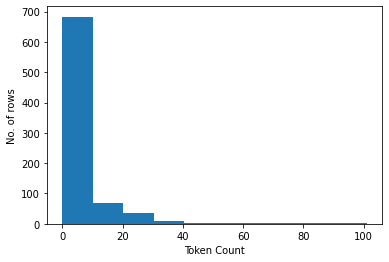

In [34]:
"""
Number of tokens per row
"""
plt.hist(df['token_count'])
plt.ylabel('No. of rows')
plt.xlabel('Token Count')
plt.show()

Roughly 85% of the rows have ≤10 tokens.

Roughly 93% of the rows have ≤20 tokens.

(see percentages in next cell)

In [35]:
"""
Token count ranges -- Percentages of total rows
"""
df['token_count'].value_counts(normalize=True, bins=10).head(5)

(-0.10200000000000001, 10.1]    0.845297
(10.1, 20.2]                    0.085396
(20.2, 30.3]                    0.045792
(30.3, 40.4]                    0.012376
(50.5, 60.6]                    0.003713
Name: token_count, dtype: float64

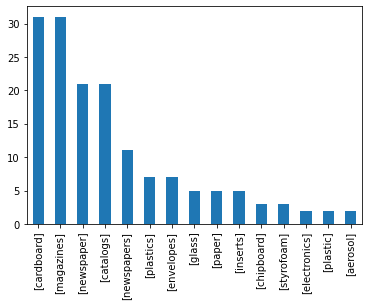

In [36]:
"""
21% of rows have 1 token.
8 of the top 9 are paper items.
"""
df.loc[df['token_count'] == 1, 'tokens'].value_counts().head(15).plot(kind='bar')
plt.show()

<AxesSubplot:>

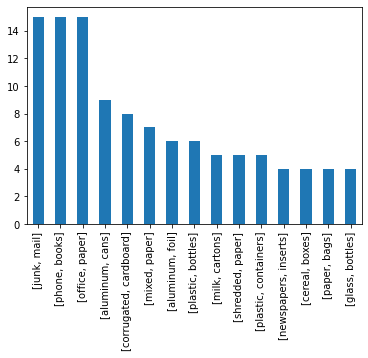

In [37]:
"""
27% of rows have 2 tokens.
Many entries are [adjective + noun].
Many are about paper items, as well as other waste (foil, cans).

12% of rows have 3 tokens. (figure not shown)
Many are also [adjective, noun] combinations.
Many are single categories (e.g. 'frozen food boxes', 'aluminum beverage cans').
"""
df.loc[df['token_count'] == 2, 'tokens'].value_counts().head(15).plot(kind='bar')

In [38]:
# Large token count exampele
df.sort_values('token_count', ascending=False).text.head(1)

536    paper\nbeverage carriers\nblueprints\nbooklets\nbrochures and flyers\nchurch bulletins\nconstruction paper\ncracker/\nfolders\ngreeting cards\nindex cards\ninstruction manuals\n\n and \nmanilla \nmilk and \n\n\npaper plates\npaper towel tubes\n\n\n\nsoft back books\nsprial notebooks\ntissue paper\ngift bags\n\nbutter tubs\ncarryout containers\ncondiment bottles\ncontact solution bottles\ndeodorant tubes\nfrozen food trays\ngarden planter containers\nlaundry baskets\nlaundry detergent bottles\nmilk crates\nplastic buckets\nplastic hangars\nproduce containers\nsalad dressing bottles\nshampoo bottles\nsoda \nsolo cups\nstorage totes\ntupperware\nwater bottles\nyogurt containers\n\ncoffee cans\ndisposable \njar lids\nmetal hangars\npet \npots and pans\nsoda and beer cans\nsoup cans\ntuna cans\nwire baskets\nfruit and vegetables trays
Name: text, dtype: object

INTERPRETATION OF TOKEN COUNT DATA:

Roughly 60% of the rows [token_count = 1-3] seem to be single categories that do not need much processing other than removing digits/symbols and (maybe) tokenizing. This percentage is probably higher, as many other rows [token_count = 4-5] can also be considered a single category, but the categorization gets less clear the higher the token count. For example, is "Aluminum Foil and Cat Food Cans" one category or two? Is "Newspaper, magazines, office paper, books" one category or four? More information on the classification task is needed to make these decisions.

Rows with higher token counts (see example in cell immediately above) tend to contain multiple categories, which are often helpfully separated with commas or new-line characters. However, tokenizing these text entries breaks up multi-word categories, which loses these inherent connections. For example, "tin cans, waxed paper, plastic wrap" gets separated into ['tin', 'cans', 'waxed', 'paper', 'plastic', 'wrap']. The n-gram exercise below regains some of these, but not all. 

How to deal with these messier rows? They could be split on commas/new-line characters to preserve the categories, but should each split become its own row? Should tokenizing be abandoned to instead focus on building and preserving discrete multi-word categories? Again, these are questions that require more knowledge of the machine learning task. Some cleaning of these rows is attempted below.

------------------ 
### B. FREQUENT WORDS, N-GRAMS

In [39]:
"""Function to calculate basic statistics about tokens in the corpus"""
def count(tokens):
    # stores the count of each token
    word_counts = Counter()
    
    # stores the number of docs that each token appears in 
    appears_in = Counter()

    total_docs = len(tokens)

    for token in tokens:
        # stores count of every appearance of a token 
        word_counts.update(token)
        # use set() in order to not count duplicates, thereby count the num of docs that each token appears in
        appears_in.update(set(token))

    # build word count dataframe
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank the the word counts
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # calculate the percent total of each token
    wc['pct_total'] = wc['count'].apply(lambda token_count: token_count / total)

    # calculate the cumulative percent total of word counts 
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    # create dataframe for document stats
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    
    # merge word count stats with doc stats
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [40]:
# Word count dataframe with corpus stats
wc  = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
22,paper,155,273,1.0,0.054996,0.054996,0.191832
5,cans,124,165,2.0,0.033239,0.088235,0.153465
33,bottles,114,165,3.0,0.033239,0.121475,0.141089
2,plastic,114,155,4.0,0.031225,0.152699,0.141089
18,boxes,75,129,5.0,0.025987,0.178687,0.092822


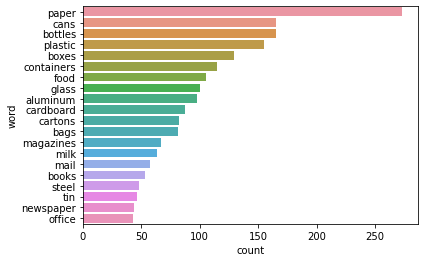

In [41]:
# Top 20 most common words
sns.barplot(x='count', y='word', data=wc.head(20))
plt.show()

In [42]:
"""Function to identify and rank n-grams"""
def get_top_ngram(corpus, n=None):
    corpus = corpus.apply(lambda text: ''.join(c for c in text if not c.isdigit()))
    vec = text.CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

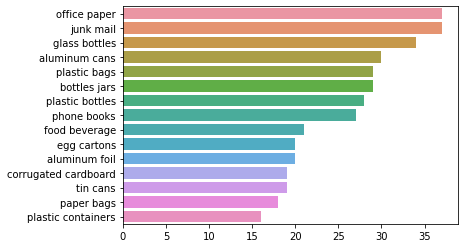

In [43]:
# Top n bigrams
n = 15
top_n_bigrams = get_top_ngram(df['text'], 2)[:n] 
x, y = map(list, zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)
plt.show()

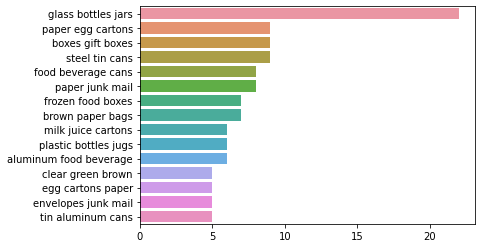

In [44]:
# Top n trigrams
n = 15
top_tri_grams = get_top_ngram(df['text'], n=3)[:n]
x, y = map(list, zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

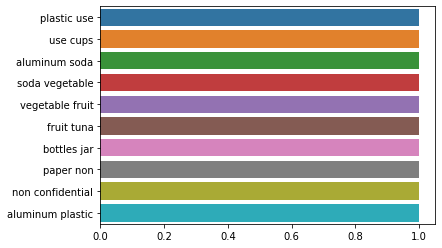

In [45]:
# Bottom n bigrams
n = 10
top_n_bigrams = get_top_ngram(df['text'], 2)[-n:] 
x, y = map(list, zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)
plt.show()

B. INTERPRETATION OF FREQUENT WORDS, N-GRAMS

The top 20 most common words in the dataset contain 7 materials, 6 container types (including the word "containers"), and 5 paper items (including the No. 1 word "paper"). Connections between the top words are easy and intuitive to make, such as "office paper" or "tin cans". 

These connections are backed up by the top 15 bigrams, which include both the examples above, as well as things like "plastic bottles" and "paper bags." My best guess as to the source of the dataset would be something related to recycling. The data also contains a column called "image_coordinates" so perhaps these are text descriptions of images of the contents of waste/recycling containers. 

Given that much of the text data is adjective+noun (even in text entries with multiple categories) some kind of part-of-speech analysis could be helpful.

----------------------- 
### C. PARTS OF SPEECH

In [46]:
"""
Add part-of-speech tags for nouns, adjectives
"""
docs = wc['word'].apply(lambda text: sp(text))
wc['noun'] = 0
wc['adj'] = 0
for doc in docs:
    for token in doc:
        if token.pos_ == 'NOUN':
            wc.loc[wc['word'] == token.text, 'noun'] += 1
        if token.pos_ == 'ADJ':
            wc.loc[wc['word'] == token.text, 'adj'] += 1

In [47]:
print('Top 10 nouns')
print(wc[wc['noun']==1][['word', 'rank']].head(10))
print('\nBottom 5 nouns')
print(wc[wc['noun']==1][['word', 'rank']].tail(5))

Top 10 nouns
          word  rank
22       paper   1.0
5         cans   2.0
33     bottles   3.0
2      plastic   4.0
18       boxes   5.0
1   containers   6.0
9         food   7.0
35       glass   8.0
10    aluminum   9.0
89   cardboard  10.0

Bottom 5 nouns
                  word   rank
753                  v  763.0
765          canssteel  767.0
767  plasticcontainers  768.0
769             bakery  770.0
770             pounds  772.0


In [48]:
print('Top 10 adjectives')
print(wc[wc['adj']==1][['word', 'rank']].head(10))
print('\nBottom 5 adjectives')
print(wc[wc['adj']==1][['word', 'rank']].tail(5))

Top 10 adjectives
           word   rank
31        clear   42.0
30        green   49.0
90        white   52.0
168       mixed   59.0
332  recyclable   68.0
41        light   78.0
339     laundry   90.0
14          non   93.0
615     aseptic  120.0
405       rigid  128.0

Bottom 5 adjectives
             word   rank
746       various  751.0
760          high  758.0
768        yellow  769.0
771      multiple  771.0
775  confidential  776.0


C. INTERPRETATION OF PARTS OF SPEECH

The top 10 nouns are all recyclable materials or objects. Some of these may in fact be adjectives in the corpus (e.g. "food" containers or "aluminumn" cans). This raises the question as to what is important to the classification task. Is trying to identify certain materials, such as paper and glass? If so, a paper envelope can be grouped together with a book. Or is it interested in types of objects? This would put glass and plastic bottles together. 

Initially, the bottom-ranked items for both nouns and adjectives included several words that appeared jammed together (e.g. "plasticcontainers" or "paperpizza"). This suggested a problem with the data cleaning process, and modifying the regular expression used during tokenization eliminated many (but not all) of these. 

----------------
### D. Multi-category entry cleaning

In [71]:
"""Function to clean and split text entries"""
def clean_text(df):
    """
    Actions:
    Lowercase
    Replace \n, \t, : with commas
    Split on commas
    Remove empty or 1-2 character entries
    Remove non-alphanumeric characters
    """
    df = df.copy()
    df['clean_text'] = df['text'].apply(lambda text: text.lower())
    df['clean_text'] = df['clean_text'].apply(lambda text: text.replace('\n', ','))
    df['clean_text'] = df['clean_text'].apply(lambda text: text.replace('\t', ','))
    df['clean_text'] = df['clean_text'].apply(lambda text: text.replace(':', ','))
    df['clean_text'] = df['clean_text'].apply(lambda text: text.split(','))
    df['clean_text'] = df['clean_text'].apply(lambda text: [token for token in text if len(token) > 2])

    clean_text = df['clean_text'].tolist()
    for i, row in enumerate(clean_text):
        for j, entry in enumerate(row):
            row[j] = re.sub('[^a-zA-Z ]', ' ', entry)
    df['clean_text'] = clean_text
            
    return df

In [76]:
df_clean = clean_text(df)
print('Example of text before and after cleaning.\n')
print('Original text:\n', df_clean[['text']].iloc[-5].item())
print('\nClean text:\n', df_clean[['clean_text']].iloc[-5].item())

Example of text before and after cleaning.

Original text:
 paper products:  , ,  printer paper, copier paper, mail and all other  without wax liners: packing boxes, , gift boxes and . flatten boxes before placing in your cart
cans: ; aluminum bottles are also accepted
cartons: aseptic poly-coated drink boxes

Clean text:
 ['paper products', '  printer paper', ' copier paper', ' mail and all other  without wax liners', ' packing boxes', ' gift boxes and   flatten boxes before placing in your cart', 'cans', '   aluminum bottles are also accepted', 'cartons', ' aseptic poly coated drink boxes']


In [80]:
print('No. of rows in dataframe:', len(df))
print('Counts of the number of clean-text sections the text entries were split into:')
print('(e.g. in 578 rows the text was split into 1 section; in 75 rows it was split into 2 sections)')
df_clean['clean_text'].apply(lambda text: len(text)).sort_values(ascending=False).value_counts().head(10)

No. of rows in dataframe: 808
Counts of the number of clean-text sections the text entries were split into:
(e.g. in 578 rows the text was split into 1 section; in 75 rows it was split into 2 sections)


1     578
2      75
3      41
4      27
5      14
6      12
10     11
7       9
9       6
12      6
Name: clean_text, dtype: int64

D. MULTI-CATEGORY ENTRY CLEANING INTERPRETATION

As can be seen above, the text entries were cleaned and split on commas, creating a list of strings for each row. This was somewhat successful in creating discrete items out of large categories. This is especially evident in the rows with large text entries. However, it also created some problems by splitting up discrete sections into multiple strings. For example, "Clear, green, and brown bottles and jars" was split into ['Clear', 'green', 'and brown bottles and jars'], which is not necessarily an improvement. Also, not all entries are simply adjective+noun constructs. Some appear to be more narrative descriptions, such as "flatten boxes before placing in your cart", which can be seen in the example above. 

It may not be possible to fully automate the text processing pipeline. Depending on how the data is going to be used, it may be best to flag certain rows for human checking. Based on my analysis, at very least about 2/3 of the rows would not need human checking. Many other rows can be easily approved for automated processing. The remainder can go through some kind of manual processing or be discarded, depending on resources and data needs. Perhaps more knowledge about how the data is gathered would provide insights into how to improve text processing. 

----------------- 
### CONCLUSION AND NEXT STEPS

The majority of text entries in this dataset are discrete categories composed of a handful of words. However, in a significant minority of rows (~30%) the text clearly contains multiple categories. 

* **"No text - category selected manually":**  Nearly 200 rows had this as the text entry. This is nearly 20% of the rows and a significant loss for a dataset of this size. Investigating these rows should be a top priority. (Interesting tidbits: All of the "No text" rows have "checkbox" in the "manual_override" column. All rows with proper text entries have "text" or "NaN" in this column. And all proper text entries that are "NaN" for "manual_override" have a value in the "image_coordinates" column, while those with "text" for "manual_override" have "NaN" for "image_coordinates".)

* **Other features:** This analysis has focused on the text entries, but there are 9 other columns that could potentially be useful. At first glance the most interesting is the "yes_no" column, with 84% of the entries "yes". What does this signify? A cursory examination showed that some text rows are "negative" (e.g. "No cans") and that these correspond to "no" values in the "yes_no" column, but there are many more "no" rows than rows with negative text entries.  

* **Data source:** Particularly if data will be collected continuously (as opposed to just using this set for model training), a better understanding of the source of the data could be beneficial. If the "No text - category selected manually" rows are included, more than half the rows are either useless or not usable without processing. Figuring out how to reduce missing text and improve the quality of incoming data would help reduce the need for text processing, which can produce unwanted or unpredictable results. 

----------------------- 
### Save data to CSV

In [52]:
# Include rows with "No text - category selected manually"
df_no_text['token_count'] = np.nan
df_no_text['clean_text'] = np.nan
df_no_text['tokens'] = np.nan
# df_no_text = df_no_text[['text', 'clean_text', 'token_count', 'tokens']]

In [55]:
df_all_data = pd.concat([df_no_text, df_clean], axis=0).sort_index()
df_all_data.head()

,id,text,added_datetime,yes_no,image_coordinates,image_url,original_id,page_number,parser_version,model_version,manual_override,token_count,clean_text,tokens
0,462548,No plastic bags or pesticide containers .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 699, 'x2': 913, 'y1': 367, 'y2': 503}",NaN,NaN,NaN,NaN,NaN,NaN,4.0,[no plastic bags or pesticide containers ],"[plastic, bags, pesticide, containers]"
1,462549,No paint or aerosol cans .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 695, 'x2': 909, 'y1': 740, 'y2': 876}",NaN,NaN,NaN,NaN,NaN,NaN,3.0,[no paint or aerosol cans ],"[paint, aerosol, cans]"
2,462550,Tin and aluminum food and drink cans .,2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 224, 'x2': 438, 'y1': 771, 'y2': 907}",NaN,NaN,NaN,NaN,NaN,NaN,5.0,[tin and aluminum food and drink cans ],"[tin, aluminum, food, drink, cans]"
3,462551,Corrugated and non corrugated . Includes cereal - type boxes and egg cartons .,2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 224, 'x2': 438, 'y1': 630, 'y2': 766}",NaN,NaN,NaN,NaN,NaN,NaN,9.0,[corrugated and non corrugated includes cereal type boxes and egg cartons ],"[corrugated, non, corrugated, includes, cereal, type, boxes, egg, cartons]"
4,462552,"Includes all colors office paper , newspapers , magazines , catalogs , envelopes with windows , and phone books .",2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 225, 'x2': 439, 'y1': 499, 'y2': 635}",NaN,NaN,NaN,NaN,NaN,NaN,11.0,"[includes all colors office paper , newspapers , magazines , catalogs , envelopes with windows , and phone books ]","[includes, colors, office, paper, newspapers, magazines, catalogs, envelopes, windows, phone, books]"


In [54]:
df_all_data.to_csv('takehome_CLEANED.csv', index=False)